# Woofer-Tweeter Offloading

Compute the matrix that maps woofer commands onto the tweeter:
\begin{align}
\alpha_\mathrm{tweeter} = R_\mathrm{woofer}^+ R_\mathrm{tweeter} \alpha_\mathrm{woofer}
\end{align}

where $R_\mathrm{woofer}^+$ is the pseudo-inverse of the woofer response matrix.


Things to investigate:
* Removing pixels that correspond to non-physical actuators
    * You can probably sorta do this by thresholding to the first 97 modes, but that's just for the woofer
* Figuring out the right threshold for the pseudo-inverse
    * Show SVD plot
    * Show modes?

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

rcParams_update = {
    'figure.dpi' : 100,
    'font.size' : 14,
    'image.origin' : 'lower'
}
plt.rcParams.update(rcParams_update)

import numpy as np
from scipy import linalg


# Functions

In [239]:

def pseudoinverse_svd(matrix, abs_threshold=None, rel_threshold=None, n_threshold=None):
    '''
    Compute the pseudo-inverse of a matrix via an SVD and some threshold.
    
    Only one type of threshold should be specified.
    
    Parameters:
        matrix: nd array
            matrix to invert
        abs_threshold: float
            Absolute value of sing vals to threshold
        rel_threshold: float
            Threshold sing vals < rel_threshold * max(sing vals)
        n_threshold : int
            Threshold beyond the first n_threshold singular values
        
    Returns:
        pseudo-inverse : nd array
            pseduo-inverse of input matrix
        threshold : float
            The absolute threshold computed
        U, s, Vh: nd arrays
            SVD of the input matrix
    '''
    
    if np.count_nonzero([abs_threshold is not None,
                         rel_threshold is not None,
                         n_threshold is not None]) > 1:
        raise ValueError('You must specify only one of [abs_threshold, rel_threshold, n_threshold]!')
        
    # take the SVD
    U, s, Vh = np.linalg.svd(matrix, full_matrices=False)
        
    #threshold
    if abs_threshold is not None:
        threshold = abs_threshold
        reject = s <= threshold
    elif rel_threshold is not None:
        threshold = s.max() * rel_threshold
        reject = s <= threshold
    elif n_threshold is not None:
        reject = np.arange(len(s)) < n_threshold
        threshold = s[n_threshold]
    else:
        threshold = 1e-16
        reject = s <= threshold
    
    sinv = np.diag(1./s) # compute the inverse (this could create NaNs)
    sinv[reject] = 0. #remove elements that don't meet the threshold
    
    # just to be safe, remove any NaNs or infs
    sinv[np.isnan(sinv)] = 0.
    sinv[np.isinf(sinv)] = 0.
    
    # compute the pseudo-inverse: Vh s^-1 U_dagger (hermitian conjugate)
    return np.dot(Vh, np.dot(sinv, U.T.conj())), threshold, U, s, Vh

def plot_singular_values(sing_vals, threshold=None):
    
    fig, ax = plt.subplots(1, 1, figsize=(5,4))
    ax.semilogy(range(1, n+1), sing_vals,label='Sing. Values')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    if threshold is not None:
        ax.hlines(threshold, xlim[0], xlim[1], linestyles='--', label='Threshold={:.2e}'.format(threshold))
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('N (woofer modes)')
    ax.set_ylabel('Singular Value')
    ax.legend()
    
    return fig, ax

def compute_woofer_tweeter_matrix(woofer_respM, tweeter_respM, **kwargs):
    woofer_inv, _ = pseudoinverse_svd(woofer_respM, **kwargs)
    return np.dot(woofer_inv, tweeter_respM)

# dev on random data

In [240]:
m, n = 2500, 121
R = np.random.randn(m, n) + 1.j*np.random.randn(m, n)
threshold = 61.

In [241]:
Rinv, threshold, U, s, Vh = pseudoinverse_svd(R, n_threshold=97)

(<Figure size 500x400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x635b364e0>)

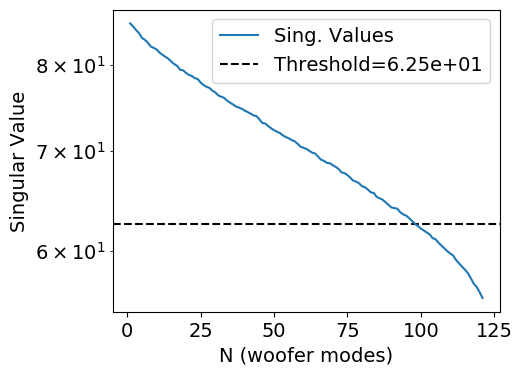

In [242]:
plot_singular_values(s, threshold)

# dev on cacao data